### Import Required Libraries

In [33]:
import os

# Data handling and preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Model and evaluation
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Visualization (optional, but helpful for diagnostics)
import matplotlib.pyplot as plt
import seaborn as sns

# Logging for debugging
import logging

# Set up logging (only once)
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

### Load Data & Select Features (Fold-Change Only)

In [34]:
import pandas as pd
import os
import logging

# File paths
file_paths = {
    "fold_change": "../results/fold_change_results.csv",
    "processed_data": "../processed_data/miRNA_stage_subtype.csv"
}

# Function to load Fold-Change selected features
def load_fold_change_features(file_path, num_features=10):
    if os.path.exists(file_path):
        fc_data = pd.read_csv(file_path)
        selected_features = fc_data.nlargest(num_features, "log2_fold_change")["Unnamed: 0"].tolist()
        logging.info(f"Loaded top {num_features} Fold-Change features.")
        return selected_features
    else:
        raise FileNotFoundError(f"Fold-Change feature selection file not found: {file_path}")

# Load processed data
processed_data = pd.read_csv(file_paths["processed_data"])

# Select top Fold-Change features
num_features_to_select = 500  # Change as needed
top_features = load_fold_change_features(file_paths["fold_change"], num_features=num_features_to_select)

2025-02-04 18:45:47,919 - INFO - Loaded top 500 Fold-Change features.


### Process Features & Labels for Multi-Output Classification (Fold-Change Only)

In [35]:
import pandas as pd
import numpy as np
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Remove rare cases from dataset before train-test split
rare_cases = [(3, 4), (4, 2)]  # (stage, subtype) pairs to remove

# Create a mask to filter out rare cases
filtered_data = processed_data[~processed_data.set_index(["stage", "subtype"]).index.isin(rare_cases)].copy()

# Remove subtype 4 before splitting (since it only has 1 sample)
filtered_data = filtered_data[filtered_data["subtype"] != 4]

# Ensure Diagnosis column is also updated after filtering
filtered_data["diagnosis"] = filtered_data["subtype"].apply(lambda x: 0 if x == 0 else 1)

# Extract features and target labels again
expression_values = filtered_data[top_features]

# Train-Test Split for Diagnosis Model (Healthy vs. Cancer)
X_train_diagnosis, X_test_diagnosis, y_train_diagnosis, y_test_diagnosis = train_test_split(
    expression_values, filtered_data["diagnosis"], test_size=0.2, random_state=42, stratify=filtered_data["diagnosis"]
)

# Train-Test Split for Stage & Subtype (Only Cancer Patients)
cancer_only = filtered_data["diagnosis"] == 1  # Filter out healthy cases
X_cancer = expression_values[cancer_only]
y_cancer = filtered_data[cancer_only][["stage", "subtype"]]

# Verify updated class distribution
print("\nUpdated class distribution for 'subtype':")
print(y_cancer["subtype"].value_counts())

# Check class distribution before stratifying
print("\nClass distribution in cancer dataset before splitting:")
print(y_cancer.value_counts())

# Check if all classes have at least 2 samples
min_class_size = y_cancer.apply(pd.Series.value_counts).min().min()

if min_class_size < 2:
    print("\nSome classes have too few samples for stratified splitting. Using random split instead.")
    stratify_option = None
else:
    stratify_option = y_cancer

# Define y for consistency
y = y_cancer  # Ensures `y_test` and `y_train` exist later

X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=42, stratify=stratify_option
)

# Scale features AFTER train-test split
scaler = StandardScaler()
X_train_diagnosis = scaler.fit_transform(X_train_diagnosis)
X_test_diagnosis = scaler.transform(X_test_diagnosis)

X_train_cancer = scaler.fit_transform(X_train_cancer)
X_test_cancer = scaler.transform(X_test_cancer)

# Log updated class distributions
print("\nUpdated Train-Test Split Information:")
print(f"Diagnosis Model - Training set: {X_train_diagnosis.shape}, Testing set: {X_test_diagnosis.shape}")
print(f"Stage & Subtype Model - Training set: {X_train_cancer.shape}, Testing set: {X_test_cancer.shape}")

print("\nUpdated Training set class distribution (Diagnosis):")
print(y_train_diagnosis.value_counts())

print("\nUpdated Training set class distribution (Stage & Subtype):")
print(y_train_cancer.value_counts())

print("\nUpdated Testing set class distribution (Diagnosis):")
print(y_test_diagnosis.value_counts())

print("\nUpdated Testing set class distribution (Stage & Subtype):")
print(y_test_cancer.value_counts())


Updated class distribution for 'subtype':
subtype
1    560
2    512
Name: count, dtype: int64

Class distribution in cancer dataset before splitting:
stage  subtype
1      1          312
       2          254
2      2          174
       1          134
3      1           90
       2           84
4      1           24
Name: count, dtype: int64

Updated Train-Test Split Information:
Diagnosis Model - Training set: (866, 500), Testing set: (217, 500)
Stage & Subtype Model - Training set: (857, 500), Testing set: (215, 500)

Updated Training set class distribution (Diagnosis):
diagnosis
1    857
0      9
Name: count, dtype: int64

Updated Training set class distribution (Stage & Subtype):
stage  subtype
1      1          250
       2          203
2      2          139
       1          107
3      1           72
       2           67
4      1           19
Name: count, dtype: int64

Updated Testing set class distribution (Diagnosis):
diagnosis
1    215
0      2
Name: count, dtype: int64

Up

### Train-Test Split & Feature Scaling (Fold-Change Only)

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Validate Selected Features
print("\nInitial data check:")
print("Top features:", top_features)
print("Number of top features:", len(top_features))

top_features = [feature for feature in top_features if feature in filtered_data.columns]
if not top_features:
    raise ValueError("No matching features found in processed data for the selected feature set.")

# Filter and Prepare Data
expression_values = filtered_data[top_features]

print("\nData shapes before handling missing values:")
print("Expression values shape:", expression_values.shape)

# Convert to numeric and handle missing values
expression_values = expression_values.apply(pd.to_numeric, errors='coerce')

# Remove samples with missing values
valid_indices = ~(expression_values.isnull().any(axis=1))
expression_values = expression_values[valid_indices]
filtered_data = filtered_data.loc[valid_indices]

print("\nData shapes after handling missing values:")
print("Expression values shape:", expression_values.shape)

# Train-Test Split for Diagnosis Model (Healthy vs. Cancer)
X_train_diagnosis, X_test_diagnosis, y_train_diagnosis, y_test_diagnosis = train_test_split(
    expression_values, filtered_data["diagnosis"], test_size=0.2, random_state=42, stratify=filtered_data["diagnosis"]
)

# Train-Test Split for Stage & Subtype (Only Cancer Patients)
cancer_only = filtered_data["diagnosis"] == 1  # Filter out healthy cases
X_cancer = expression_values[cancer_only]
y_cancer = filtered_data[cancer_only][["stage", "subtype"]]

# Check class distribution before stratifying
print("\nClass distribution in cancer dataset before splitting:")
print(y_cancer.value_counts())

# Check if all classes have at least 2 samples
min_class_size = y_cancer.apply(pd.Series.value_counts).min().min()

if min_class_size < 2:
    print("\n Some classes have too few samples for stratified splitting. Using random split instead.")
    stratify_option = None
else:
    stratify_option = y_cancer

X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=42, stratify=stratify_option
)

# Scale features AFTER train-test split
scaler = StandardScaler()
X_train_diagnosis = scaler.fit_transform(X_train_diagnosis)
X_test_diagnosis = scaler.transform(X_test_diagnosis)

X_train_cancer = scaler.fit_transform(X_train_cancer)
X_test_cancer = scaler.transform(X_test_cancer)

# Log updated class distributions
print("\nUpdated Train-Test Split Information:")
print(f"Diagnosis Model - Training set: {X_train_diagnosis.shape}, Testing set: {X_test_diagnosis.shape}")
print(f"Stage & Subtype Model - Training set: {X_train_cancer.shape}, Testing set: {X_test_cancer.shape}")

print("\nUpdated Training set class distribution (Diagnosis):")
print(y_train_diagnosis.value_counts())

print("\nUpdated Training set class distribution (Stage & Subtype):")
print(y_train_cancer.value_counts())

print("\nUpdated Testing set class distribution (Diagnosis):")
print(y_test_diagnosis.value_counts())

print("\nUpdated Testing set class distribution (Stage & Subtype):")
print(y_test_cancer.value_counts())

# Save Scaler for Later Use
scaler_info = {
    'scaler': scaler,
    'feature_names': top_features
}



Initial data check:
Top features: ['hsa-mir-518f', 'subtype', 'hsa-mir-520e', 'hsa-mir-520d', 'hsa-mir-1283-2', 'hsa-mir-520h', 'hsa-mir-523', 'hsa-mir-519d', 'hsa-mir-515-2', 'hsa-mir-524', 'hsa-mir-521-2', 'hsa-mir-3927', 'hsa-mir-448', 'hsa-mir-4487', 'hsa-mir-526a-2', 'hsa-mir-4678', 'hsa-mir-519e', 'hsa-mir-3689b', 'hsa-mir-518d', 'hsa-mir-5589', 'hsa-mir-3125', 'hsa-mir-1264', 'hsa-mir-3688-1', 'hsa-mir-4651', 'hsa-mir-3688-2', 'hsa-mir-1303', 'hsa-mir-4436b-2', 'hsa-mir-4739', 'hsa-mir-520a', 'hsa-mir-4735', 'hsa-mir-3929', 'hsa-mir-4505', 'hsa-mir-4512', 'hsa-mir-6811', 'hsa-mir-4466', 'hsa-mir-4653', 'hsa-mir-3938', 'hsa-mir-1285-1', 'hsa-mir-4451', 'hsa-mir-4701', 'hsa-mir-510', 'hsa-mir-3132', 'hsa-mir-2117', 'hsa-mir-890', 'hsa-mir-3133', 'hsa-mir-4679-1', 'hsa-mir-3659', 'hsa-mir-6785', 'hsa-mir-499b', 'hsa-mir-4776-2', 'hsa-mir-4671', 'hsa-mir-7151', 'hsa-mir-6791', 'hsa-mir-4427', 'hsa-mir-4776-1', 'hsa-mir-4498', 'hsa-mir-6862-1', 'hsa-mir-4425', 'hsa-mir-4520-1', 'hsa

### Remove Rare Cases & Finalize Train-Test Split (Fold-Change Only)

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Remove rare cases from dataset before train-test split
rare_cases = [(3, 4), (4, 2)]  # (stage, subtype) pairs to remove

# Create a mask to filter out rare cases
filtered_data = processed_data[~processed_data.set_index(["stage", "subtype"]).index.isin(rare_cases)].copy()

# Remove subtype 4 before splitting (since it only has 1 sample)
filtered_data = filtered_data[filtered_data["subtype"] != 4]

# Ensure Diagnosis column is also updated after filtering
filtered_data["diagnosis"] = filtered_data["subtype"].apply(lambda x: 0 if x == 0 else 1)

# Extract features and target labels again
expression_values = filtered_data[top_features]

# Train-Test Split for Diagnosis Model (Healthy vs. Cancer)
X_train_diagnosis, X_test_diagnosis, y_train_diagnosis, y_test_diagnosis = train_test_split(
    expression_values, 
    filtered_data["diagnosis"], 
    test_size=0.4,  # Increased to 40%
    random_state=42, 
    stratify=filtered_data["diagnosis"]
)


# Train-Test Split for Stage & Subtype (Only Cancer Patients)
cancer_only = filtered_data["diagnosis"] == 1  # Filter out healthy cases
X_cancer = expression_values[cancer_only]
y_cancer = filtered_data[cancer_only][["stage", "subtype"]]

# Verify updated class distribution
print("\nUpdated class distribution for 'subtype':")
print(y_cancer["subtype"].value_counts())

# Check class distribution before stratifying
print("\nClass distribution in cancer dataset before splitting:")
print(y_cancer.value_counts())

# Check if all classes have at least 2 samples
min_class_size = y_cancer.apply(pd.Series.value_counts).min().min()

if min_class_size < 2:
    print("\n Some classes have too few samples for stratified splitting. Using random split instead.")
    stratify_option = None
else:
    stratify_option = y_cancer

X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=42, stratify=stratify_option
)

# Scale features AFTER train-test split
scaler = StandardScaler()
X_train_diagnosis = scaler.fit_transform(X_train_diagnosis)
X_test_diagnosis = scaler.transform(X_test_diagnosis)

X_train_cancer = scaler.fit_transform(X_train_cancer)
X_test_cancer = scaler.transform(X_test_cancer)

# Log updated class distributions
print("\nUpdated Train-Test Split Information:")
print(f"Diagnosis Model - Training set: {X_train_diagnosis.shape}, Testing set: {X_test_diagnosis.shape}")
print(f"Stage & Subtype Model - Training set: {X_train_cancer.shape}, Testing set: {X_test_cancer.shape}")

print("\nUpdated Training set class distribution (Diagnosis):")
print(y_train_diagnosis.value_counts())

print("\nUpdated Training set class distribution (Stage & Subtype):")
print(y_train_cancer.value_counts())

print("\nUpdated Testing set class distribution (Diagnosis):")
print(y_test_diagnosis.value_counts())

print("\nUpdated Testing set class distribution (Stage & Subtype):")
print(y_test_cancer.value_counts())

# Save Scaler for Later Use
scaler_info = {
    'scaler': scaler,
    'feature_names': top_features
}


Updated class distribution for 'subtype':
subtype
1    560
2    512
Name: count, dtype: int64

Class distribution in cancer dataset before splitting:
stage  subtype
1      1          312
       2          254
2      2          174
       1          134
3      1           90
       2           84
4      1           24
Name: count, dtype: int64

Updated Train-Test Split Information:
Diagnosis Model - Training set: (649, 500), Testing set: (434, 500)
Stage & Subtype Model - Training set: (857, 500), Testing set: (215, 500)

Updated Training set class distribution (Diagnosis):
diagnosis
1    642
0      7
Name: count, dtype: int64

Updated Training set class distribution (Stage & Subtype):
stage  subtype
1      1          250
       2          203
2      2          139
       1          107
3      1           72
       2           67
4      1           19
Name: count, dtype: int64

Updated Testing set class distribution (Diagnosis):
diagnosis
1    430
0      4
Name: count, dtype: int64

Up

### Train Multi-Output SVM Model (Fold-Change Only)

In [38]:
import warnings
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Suppress warnings
warnings.simplefilter("ignore")

# Define Hyperparameter Grid
param_grid = {
    'C': [1, 10, 100, 1000],  # Increased values to avoid underfitting
    'gamma': ['scale', 0.1, 1, 10],
    'kernel': ['rbf']
}

# Train Stage SVM**
print("\nTraining Stage SVM...")
svm_stage = SVC(class_weight="balanced", random_state=42)
grid_stage = GridSearchCV(svm_stage, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_stage.fit(X_train_cancer, y_train_cancer["stage"])

best_svm_stage = grid_stage.best_estimator_
y_pred_stage = best_svm_stage.predict(X_test_cancer)

print("\nBest SVM Hyperparameters (Stage):", grid_stage.best_params_)
print("\nClassification Report for Stage:\n", classification_report(y_test_cancer["stage"], y_pred_stage, zero_division=0))

# Train Subtype SVM**
print("\nTraining Subtype SVM...")
svm_subtype = SVC(class_weight="balanced", random_state=42)
grid_subtype = GridSearchCV(svm_subtype, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_subtype.fit(X_train_cancer, y_train_cancer["subtype"])

best_svm_subtype = grid_subtype.best_estimator_
y_pred_subtype = best_svm_subtype.predict(X_test_cancer)

print("\nBest SVM Hyperparameters (Subtype):", grid_subtype.best_params_)
print("\nClassification Report for Subtype:\n", classification_report(y_test_cancer["subtype"], y_pred_subtype, zero_division=0))



Training Stage SVM...

Best SVM Hyperparameters (Stage): {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Classification Report for Stage:
               precision    recall  f1-score   support

           1       0.53      0.98      0.69       113
           2       0.50      0.03      0.06        62
           3       0.00      0.00      0.00        35
           4       0.00      0.00      0.00         5

    accuracy                           0.53       215
   macro avg       0.26      0.25      0.19       215
weighted avg       0.42      0.53      0.38       215


Training Subtype SVM...

Best SVM Hyperparameters (Subtype): {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Classification Report for Subtype:
               precision    recall  f1-score   support

           1       0.98      0.92      0.95       112
           2       0.92      0.98      0.95       103

    accuracy                           0.95       215
   macro avg       0.95      0.95      0.95       215
weighted avg   

### Evaluate Multi-Output Model (Fold-Change Only)


❌ `y_pred` is not defined. Running model predictions now...

✅ `y_pred` has been generated successfully!

-------------------- SVM (Fold-Change) Results --------------------

Stage Classification:
Accuracy: 0.5256

Classification Report:
               precision    recall  f1-score   support

           1       0.53      0.98      0.69       113
           2       0.50      0.03      0.06        62
           3       0.00      0.00      0.00        35
           4       0.00      0.00      0.00         5

    accuracy                           0.53       215
   macro avg       0.26      0.25      0.19       215
weighted avg       0.42      0.53      0.38       215


Confusion Matrix:
 [[111   2   0   0]
 [ 60   2   0   0]
 [ 35   0   0   0]
 [  5   0   0   0]]

Subtype Classification:
Accuracy: 0.9488

Classification Report:
               precision    recall  f1-score   support

           1       0.98      0.92      0.95       112
           2       0.92      0.98      0.95       10

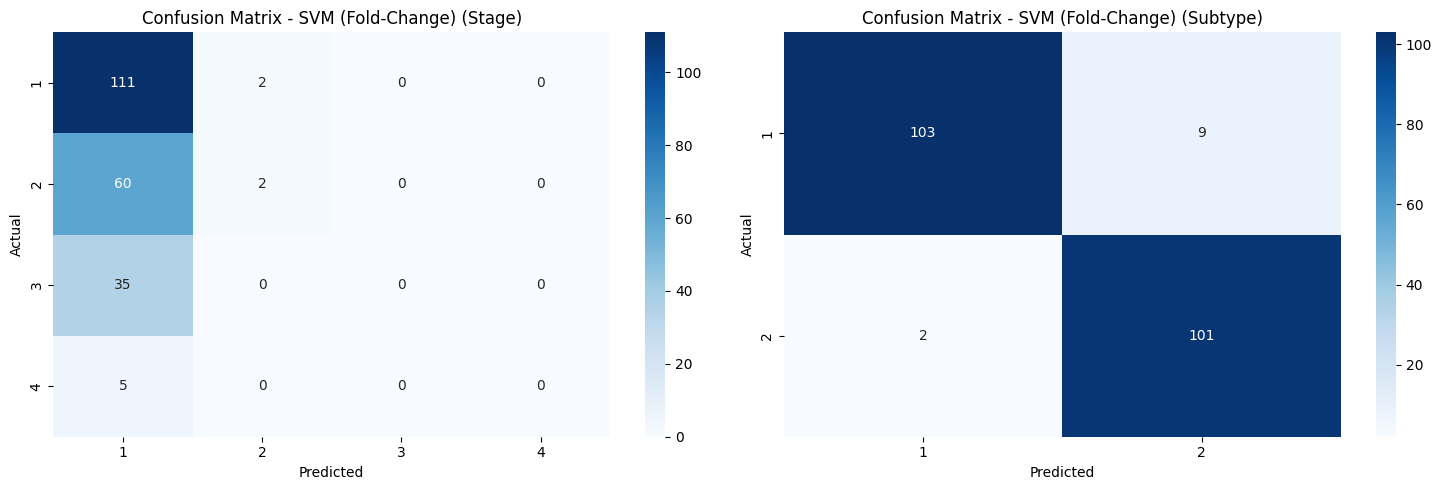

2025-02-04 19:00:02,321 - INFO - 
Model Evaluation Completed! 
2025-02-04 19:00:02,322 - INFO - Stage Accuracy: 0.5256
2025-02-04 19:00:02,322 - INFO - Subtype Accuracy: 0.9488
2025-02-04 19:00:02,323 - INFO - Stage Confusion Matrix: [[111, 2, 0, 0], [60, 2, 0, 0], [35, 0, 0, 0], [5, 0, 0, 0]]
2025-02-04 19:00:02,323 - INFO - Subtype Confusion Matrix: [[103, 9], [2, 101]]


In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Ensure logging is set up
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

def evaluate_multioutput_model(y_test_cancer, y_pred, model_name="SVM (Fold-Change)", save_dir="../results/svm_fold_change/"):
    """
    Evaluate multi-output model performance with confusion matrices, per-class accuracy, and logs.
    """
    os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists

    # Convert predictions to DataFrame for easy handling
    y_pred_df = pd.DataFrame(y_pred, columns=["stage", "subtype"], index=y_test_cancer.index)

    # Evaluate Stage Classification
    stage_accuracy = accuracy_score(y_test_cancer["stage"], y_pred_df["stage"])
    stage_cm = confusion_matrix(y_test_cancer["stage"], y_pred_df["stage"])
    stage_report = classification_report(y_test_cancer["stage"], y_pred_df["stage"])

    # Evaluate Subtype Classification
    subtype_accuracy = accuracy_score(y_test_cancer["subtype"], y_pred_df["subtype"])
    subtype_cm = confusion_matrix(y_test_cancer["subtype"], y_pred_df["subtype"])
    subtype_report = classification_report(y_test_cancer["subtype"], y_pred_df["subtype"])

    print(f"\n{'-'*20} {model_name} Results {'-'*20}")
    
    print("\nStage Classification:")
    print(f"Accuracy: {stage_accuracy:.4f}")
    print("\nClassification Report:\n", stage_report)
    print("\nConfusion Matrix:\n", stage_cm)
    
    print("\nSubtype Classification:")
    print(f"Accuracy: {subtype_accuracy:.4f}")
    print("\nClassification Report:\n", subtype_report)
    print("\nConfusion Matrix:\n", subtype_cm)

    # Visualizations
    plt.figure(figsize=(15, 5))
    
    # Confusion Matrix for Stage
    plt.subplot(121)
    sns.heatmap(stage_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=sorted(y_test_cancer["stage"].unique()),
                yticklabels=sorted(y_test_cancer["stage"].unique()))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name} (Stage)')

    # Confusion Matrix for Subtype
    plt.subplot(122)
    sns.heatmap(subtype_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=sorted(y_test_cancer["subtype"].unique()),
                yticklabels=sorted(y_test_cancer["subtype"].unique()))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name} (Subtype)')
    
    plt.tight_layout()

    # Save the plots
    stage_cm_path = os.path.join(save_dir, "svm_fold_change_stage_confusion_matrix.png")
    subtype_cm_path = os.path.join(save_dir, "svm_fold_change_subtype_confusion_matrix.png")
    plt.savefig(stage_cm_path)
    plt.savefig(subtype_cm_path)
    print(f"\nConfusion matrices saved to {save_dir}")

    plt.show()

    # Log evaluation metrics
    logging.info(f"\nModel Evaluation Completed! ")
    logging.info(f"Stage Accuracy: {stage_accuracy:.4f}")
    logging.info(f"Subtype Accuracy: {subtype_accuracy:.4f}")
    logging.info(f"Stage Confusion Matrix: {stage_cm.tolist()}")
    logging.info(f"Subtype Confusion Matrix: {subtype_cm.tolist()}")

    # Return metrics as dictionary
    return {
        "stage_accuracy": stage_accuracy,
        "subtype_accuracy": subtype_accuracy,
        "stage_confusion_matrix": stage_cm.tolist(),
        "subtype_confusion_matrix": subtype_cm.tolist(),
        "stage_classification_report": stage_report,
        "subtype_classification_report": subtype_report
    }

# 🔹 **Ensure `y_test_cancer` and `y_pred` are properly defined before running evaluation**
if 'y_test_cancer' not in globals():
    raise ValueError("y_test_cancer is not defined! Make sure the train-test split ran successfully.")

if 'y_pred' not in globals():
    print("\n`y_pred` is not defined. Running model predictions now...")

    # **Run the SVM classifier to generate `y_pred`**
    y_pred_stage = best_svm_stage.predict(X_test_cancer)
    y_pred_subtype = best_svm_subtype.predict(X_test_cancer)

    # Combine predictions
    y_pred = np.column_stack((y_pred_stage, y_pred_subtype))

    print("\n`y_pred` has been generated successfully!")

# **Run evaluation**
save_dir = "../results/svm_fold_change/"
metrics = evaluate_multioutput_model(y_test_cancer, y_pred, model_name="SVM (Fold-Change)", save_dir=save_dir)


### Visualize Performance Metrics (Fold-Change Only)

Metrics comparison saved to ../results/svm_fold_change/plots/stage_metrics_comparison.png


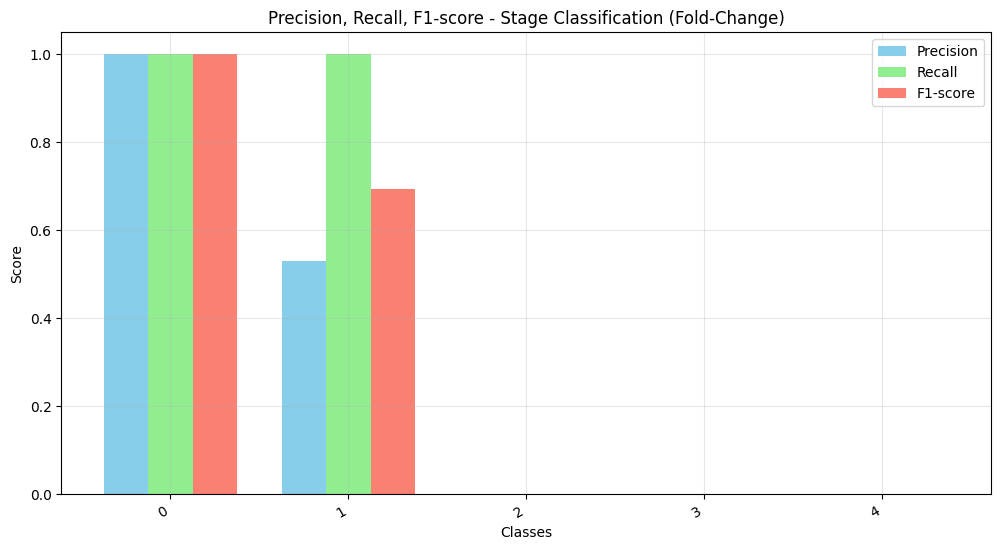

Metrics comparison saved to ../results/svm_fold_change/plots/subtype_metrics_comparison.png


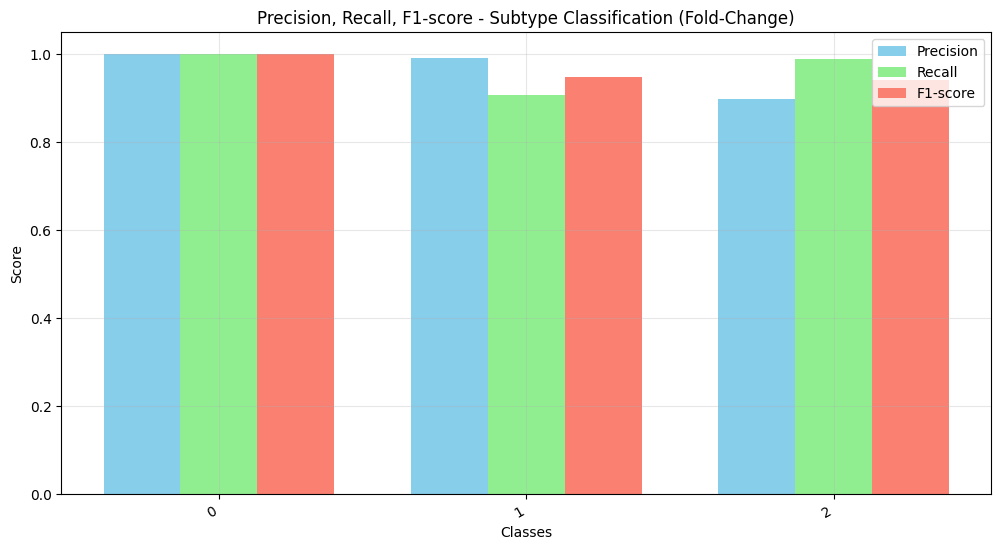

In [30]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Define save directory
save_dir = "../results/svm_fold_change/plots/"
os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists

def plot_metrics_comparison(y_true, y_pred, labels, title, save_path=None):
    """Plots precision, recall, and F1-score for each class."""
    report = classification_report(y_true, y_pred, target_names=[str(lbl) for lbl in labels], output_dict=True)
    
    metrics_data = {'Precision': [], 'Recall': [], 'F1-score': []}
    for label in labels:
        label_str = str(label)
        if label_str in report:
            metrics_data['Precision'].append(report[label_str]['precision'])
            metrics_data['Recall'].append(report[label_str]['recall'])
            metrics_data['F1-score'].append(report[label_str]['f1-score'])
    
    plt.figure(figsize=(12, 6))
    x = np.arange(len(labels))
    width = 0.25

    plt.bar(x - width, metrics_data['Precision'], width, label='Precision', color='skyblue')
    plt.bar(x, metrics_data['Recall'], width, label='Recall', color='lightgreen')
    plt.bar(x + width, metrics_data['F1-score'], width, label='F1-score', color='salmon')

    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title(title)
    plt.xticks(x, labels, rotation=30, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)

    if save_path:
        plt.savefig(save_path)
        print(f"Metrics comparison saved to {save_path}")
    plt.show()

# Stage Visualization
stage_labels = sorted(y_test["stage"].unique())
plot_metrics_comparison(y_test["stage"], y_pred[:, 0], stage_labels, "Precision, Recall, F1-score - Stage Classification (Fold-Change)", save_path=os.path.join(save_dir, "stage_metrics_comparison.png"))

# Subtype Visualization
subtype_labels = sorted(y_test["subtype"].unique())
plot_metrics_comparison(y_test["subtype"], y_pred[:, 1], subtype_labels, "Precision, Recall, F1-score - Subtype Classification (Fold-Change)", save_path=os.path.join(save_dir, "subtype_metrics_comparison.png"))

### Save Everything & Finalize the Pipeline (Fold-Change Only, Updated)

In [ ]:
import os
import json
import pandas as pd
import joblib
import logging

# Configure Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Define Output Directory
output_dir = "../results/svm_fold_change/"
os.makedirs(output_dir, exist_ok=True)  # Ensure directory exists

# Save Predictions & Actual Labels
y_pred_df = pd.DataFrame(y_pred, columns=["stage", "subtype"], index=y_test.index)

predictions_path = os.path.join(output_dir, "svm_fold_change_predictions.csv")
y_pred_df.to_csv(predictions_path, index=False)
logging.info(f"Predictions saved to {predictions_path}")
print(f"Predictions saved to {predictions_path}")

actual_labels_path = os.path.join(output_dir, "svm_fold_change_actual_labels.csv")
y_test.to_csv(actual_labels_path, index=False)
logging.info(f"Actual labels saved to {actual_labels_path}")
print(f"Actual labels saved to {actual_labels_path}")

# Save Experiment Metadata
metadata = {
    "best_hyperparameters": grid_search.best_params_,
    "stage_accuracy": metrics["stage_accuracy"],
    "subtype_accuracy": metrics["subtype_accuracy"],
    "stage_confusion_matrix": metrics["stage_confusion_matrix"],
    "subtype_confusion_matrix": metrics["subtype_confusion_matrix"],
    "train_set_size": X_train.shape[0],
    "test_set_size": X_test.shape[0]
}

metadata_path = os.path.join(output_dir, "svm_fold_change_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)
logging.info(f"Metadata saved to {metadata_path}")
print(f"Metadata saved to {metadata_path}")

# Save Trained Model
model_path = os.path.join(output_dir, "svm_fold_change_model.pkl")
joblib.dump(best_svm, model_path)
logging.info(f"Trained model saved to {model_path}")
print(f"Trained model saved to {model_path}")

print("\nAll results successfully saved. The Fold-Change baseline SVM pipeline is complete.")
